# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 04.02.2023

Мягкий дедлайн: 23:59MSK 20.02.2023

Жесткий дедлайн: 23:59MSK 26.02.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
#!pip3 install keras
#!pip3 install tensorflow

In [2]:
#!pip3 install scikit-learn-intelex

In [3]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

2023-02-20 17:40:54.077926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 17:40:54.207573: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-20 17:40:54.873447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/

In [4]:
x_train_pics.shape, x_test_pics.shape

((60000, 28, 28), (10000, 28, 28))

Посмотрим на картинки

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

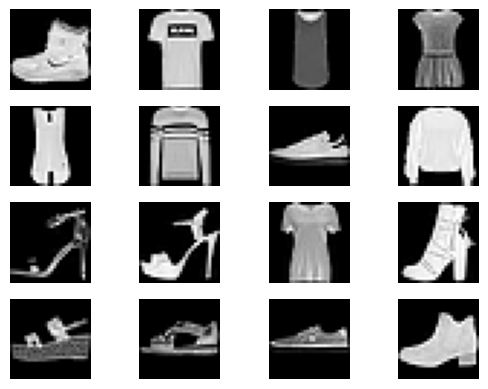

In [6]:
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train_pics[i, :], cmap='gray');
    plt.axis('off')

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

Перепишем выражение для эвристики в следующем виде

$y_{ij} = \sum_{k=1}^d (x_{ik} - x_{jk})^2 = \sum_{k=1}^d (x^2_{ik} + x^2_{jk} - 2 x_{ik} x_{jk}) = ||x_i||^2 + ||x_j||^2 - 2(x_i,x_j)$

Тогда это выражение можно записать в матричном виде, если взять 2 непересекающиеся подвыборки из объектов $X_1$ и $X_2$. А потом в получившейся матрице взять медиану. Хоть матрица и симметричная и там будут повторы, на медиану это не повлияет.

In [7]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import Normalizer


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.model = None
        self.pca = None
        self.W = None
        self.B = None
        self.scaler = None
    
    def _estimate_variance(self, X):
        num_objs = 1000
        
        # Выбираем 2 набора из 1000 случайных непересекающихся индексов
        indices_1 = np.random.choice(range(len(X)), size=num_objs, replace=False)
        indices_2 = np.random.choice(range(len(X)), size=num_objs, replace=False)
        indices_1 = np.setdiff1d(indices_1, indices_2, assume_unique=True)
        
        X_1 = X[indices_1, :]
        X_2 = X[indices_2, :]
        
        # Считаем нормы строк
        X_1_norms = np.linalg.norm(X_1, axis=1) ** 2
        X_2_norms = np.linalg.norm(X_2, axis=1) ** 2
        
        e_1 = np.ones((1, len(indices_2)))
        e_2 = np.ones((len(indices_1), 1))
        
        # Матричный вид эвристики
        Y = X_1_norms.reshape(-1, 1) @ e_1 + e_2 @ X_2_norms.reshape(1, -1) - 2 * X_1 @ X_2.T
        return np.median(Y.flatten())

    def _sample_normal(self, var, size):
        return np.random.normal(scale=1 / var, size=size)
    
    def _sample_uniform(self, size):
        return np.random.uniform(-np.pi, np.pi, size=size)
    
    def _calculate_features(self, X):
        return np.cos(X @ self.W + self.B)
    
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        self.scaler = Normalizer().fit(X)
        X = self.scaler.transform(X)
        
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim).fit(X)
            X = self.pca.transform(X)
        
        var = self._estimate_variance(X)
        self.W = self._sample_normal(var, size=(X.shape[1], self.n_features))
        self.B = self._sample_uniform(size=self.n_features)
        
        new_features = self._calculate_features(X)
        
        if self.classifier == "svm":
            self.model = SVC(kernel="linear").fit(new_features, y)
        elif self.classifier == "logreg":
            self.model = LogisticRegression(max_iter=1000).fit(new_features, y)
        else:
            raise ValueError(f"Unknown classifier {self.classifier}")
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X = self.scaler.transform(X)
            
        if self.use_PCA:
            X = self.pca.transform(X)
        X = self._calculate_features(X)
        return self.model.predict_proba(X)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X = self.scaler.transform(X)
        
        if self.use_PCA:
            X = self.pca.transform(X) 
        X = self._calculate_features(X)
        return self.model.predict(X)

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import time

Возьмем наш пайплайн с SVM и логистической регрессией и сравним с линейным SVM, а также с SVM с гауссовским ядром. 

И посчитаем accuracy, precision и recall. Классы сбалансированны, поэтому сравнивать accuracy имеет смысл.

In [10]:
def statistics(clf, x, y):
    preds = clf.predict(x)
    return {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, average='macro'),
        "recall": recall_score(y, preds, average='macro')
    }  

In [11]:
# На случай, если долго будет работать
#np.random.seed(42)
#ratio = 0.1 # если больше, то супер долго
#indices = np.random.choice(range(len(x_train)), size=int(ratio * len(x_train)), replace=False)
#len(indices)
indices = list(range(len(x_train)))
len(indices)

60000

#### Случайные признаки

Logreg classifier

In [12]:
then = time.time()
rff_pipeline = RFFPipeline(classifier="logreg").fit(x_train[indices], y_train[indices])
print("time: {:.4f}s".format(time.time() - then))

time: 30.7024s


/home/kakorolev/.conda/envs/kkorolev/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
rff_results = statistics(rff_pipeline, x_test, y_test)

rff_results

{'accuracy': 0.8808, 'precision': 0.8805721255897744, 'recall': 0.8808}

SVM classifier

In [14]:
then = time.time()
rff_pipeline_2 = RFFPipeline(classifier="svm").fit(x_train[indices], y_train[indices])
print("time: {:.4f}s".format(time.time() - then))

time: 22.0262s


In [15]:
rff_results_2 = statistics(rff_pipeline_2, x_test, y_test)

rff_results_2

{'accuracy': 0.8798, 'precision': 0.8793053169225378, 'recall': 0.8798}

#### Linear SVM

In [16]:
then = time.time()
linear_svm = LinearSVC().fit(x_train[indices], y_train[indices])
print("time: {:.4f}s".format(time.time() - then))

time: 543.4946s


/home/kakorolev/.conda/envs/kkorolev/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [17]:
linear_svm_results = statistics(linear_svm, x_test, y_test)

linear_svm_results

{'accuracy': 0.7735, 'precision': 0.804107456132129, 'recall': 0.7735}

#### RBF SVM

In [18]:
then = time.time()
rbf_svm = SVC(kernel="rbf").fit(x_train[indices], y_train[indices])
print("time: {:.4f}s".format(time.time() - then))

time: 11.2918s


In [19]:
rbf_svm_results = statistics(rbf_svm, x_test, y_test)

rbf_svm_results

{'accuracy': 0.8827, 'precision': 0.8822102702176974, 'recall': 0.8827}

### Выводы

Подход RFF действительно работает: качество сравнимое с ядровым SVM. Убедились, что линейный SVM совсем плох для более-менее сложных задач с большой размерностью признакового пространства.

По времени работает медленнее, чем ядровой SVM, так как решаются дополнительные задачи как: PCA, оценка дисперсии, генерация новых признаков, обучение классификатора. Хуже всех по времени очевидно обычный SVM, так как PCA не применялся, а признаков довольно много.

#### Catboost

In [28]:
#!pip3 install catboost
#!pip3 install optuna

In [20]:
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import train_test_split

In [21]:
def objective(trial):
    param = {
        "num_trees": trial.suggest_int("num_trees", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0, 1)
    }
    
    clf = CatBoostClassifier(**param, verbose=False).fit(x_train_, y_train_)
    preds = clf.predict(x_val_).reshape(1, -1)[0]
    accuracy = accuracy_score(y_val_, preds)
    precision = precision_score(y_val_, preds, average='macro')
    recall = recall_score(y_val_, preds, average='macro')
    return accuracy, precision, recall


pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

x_train_, x_val_, y_train_, y_val_ = train_test_split(x_train_pca, y_train, test_size=0.33, random_state=42)
study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=50)

[I 2023-02-20 18:02:01,001] A new study created in memory with name: no-name-09dfb179-2b97-4296-b67a-9072ada0ce03
[I 2023-02-20 18:02:03,162] Trial 0 finished with values: [0.8368686868686869, 0.8352476884312694, 0.8371582909742006] and parameters: {'num_trees': 41, 'learning_rate': 0.30633756377390675}. 
[I 2023-02-20 18:02:07,285] Trial 1 finished with values: [0.8427272727272728, 0.842164113459544, 0.8430347772268225] and parameters: {'num_trees': 88, 'learning_rate': 0.7940642895459621}. 
[I 2023-02-20 18:02:10,197] Trial 2 finished with values: [0.8465656565656565, 0.8456167045719145, 0.8468744618522221] and parameters: {'num_trees': 62, 'learning_rate': 0.5198598725947711}. 
[I 2023-02-20 18:02:14,431] Trial 3 finished with values: [0.8548989898989899, 0.8538493664362143, 0.8552120251877027] and parameters: {'num_trees': 90, 'learning_rate': 0.4827095750428013}. 
[I 2023-02-20 18:02:17,370] Trial 4 finished with values: [0.8459595959595959, 0.8447644969723388, 0.8462755049643433]

In [22]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trials:")
trials = study.best_trials

objectives = ["accuracy", "precision", "recall"]

for i, trial in enumerate(trials):
    print("  Metrics: {}".format(objectives))
    print("  Values: {}".format(trial.values))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trials:
  Metrics: ['accuracy', 'precision', 'recall']
  Values: [0.8561111111111112, 0.854917062098918, 0.8564356398921646]
  Params: 
    num_trees: 99
    learning_rate: 0.33723952200141294


In [24]:
then = time.time()
cb = CatBoostClassifier(num_trees=99, learning_rate=0.337, verbose=False).fit(x_train_pca, y_train)
print("time: {:.4f}s".format(time.time() - then))

time: 6.5401s


In [25]:
preds = cb.predict(x_test_pca).reshape(1, -1)[0]
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')

accuracy, precision, recall

(0.851, 0.8499750723984436, 0.851)

### Выводы

Градиентный бустинг показывает себя хуже в плане метрик, но очень быстро обучается.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Помогает ли предварительное понижение размерности с помощью PCA?

In [26]:
from tqdm.notebook import tqdm
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [27]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
def create_dict(dim, stats):
    stats["dim"] = dim
    return stats


def run_pca_experiment():
    new_dims = np.linspace(50, 700, 5)
    
    rff = RFFPipeline(use_PCA=False, classifier="logreg").fit(x_train[indices], y_train[indices])
    rff_results = statistics(rff, x_test, y_test)
    
    results = [create_dict(-1, rff_results)]
    
    for new_dim in tqdm(new_dims, desc='Iterating over PCA dimensions'):
        new_dim = int(new_dim)
        rff = RFFPipeline(new_dim=new_dim, classifier="logreg").fit(x_train[indices], y_train[indices])
        rff_results = statistics(rff, x_test, y_test)
        results.append(create_dict(new_dim, rff_results))
    
    return pd.DataFrame(results)

In [28]:
pca_experiment_df = run_pca_experiment()

Iterating over PCA dimensions:   0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
pca_experiment_df

,accuracy,precision,recall,dim
0,0.8658,0.865106,0.8658,-1
1,0.8767,0.876451,0.8767,50
2,0.8752,0.874509,0.8752,212
3,0.8670,0.866075,0.8670,375
4,0.8651,0.864642,0.8651,537
5,0.8602,0.859677,0.8602,700


In [30]:
import seaborn as sns

In [37]:
def plot_experiment_results(df, col, figsize=(10, 4)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    ax = sns.barplot(data=df, x=col, y="accuracy");
    ax.set(ylim=(0.85, 0.9));

    plt.subplot(1, 3, 2)
    ax = sns.barplot(data=df, x=col, y="precision");
    ax.set(ylim=(0.85, 0.9));

    plt.subplot(1, 3, 3)
    ax = sns.barplot(data=df, x=col, y="recall");
    ax.set(ylim=(0.85, 0.9));

    plt.tight_layout()

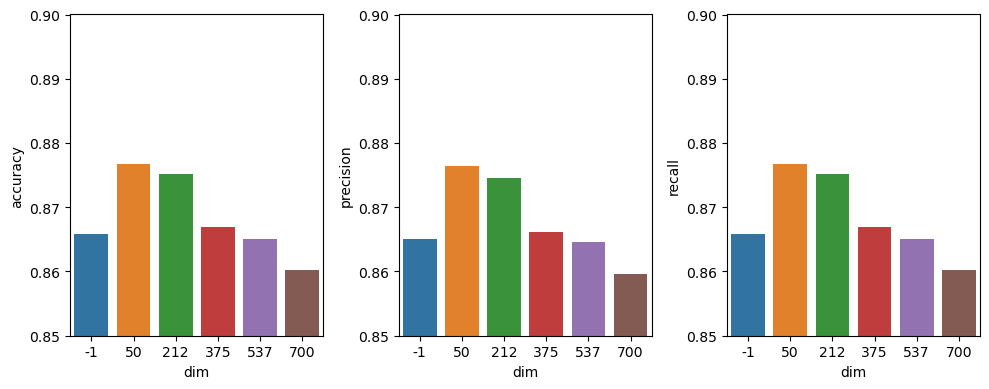

In [32]:
plot_experiment_results(pca_experiment_df, col="dim")

### Выводы

Да, понижать размерность оказывается полезным. Во-первых обучение намного быстрее, во-вторых, метрики получаются лучше. Опять же этот гиперпараметр стоит подбирать, как видно из графиков с какого-то момента качество начинает проседать.

Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?

In [33]:
def create_dict_n_features(n_features, stats):
    stats["n_features"] = n_features
    return stats

def run_nfeatures_experiment():
    n_features_range = range(500, 10000, 1000)
    results = []
    
    for nf in tqdm(n_features_range, desc='Iterating over n_features'):
        rff = RFFPipeline(n_features=nf, classifier="logreg").fit(x_train[indices], y_train[indices])
        rff_results = statistics(rff, x_test, y_test)
        results.append(create_dict_n_features(nf, rff_results))
    
    return pd.DataFrame(results)

In [34]:
nfeatures_experiment_df = run_nfeatures_experiment()

Iterating over n_features:   0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
nfeatures_experiment_df

,accuracy,precision,recall,n_features
0,0.8738,0.873201,0.8738,500
1,0.8819,0.881509,0.8819,1500
2,0.8847,0.884644,0.8847,2500
3,0.8879,0.887884,0.8879,3500
4,0.8880,0.887916,0.8880,4500
5,0.8863,0.886359,0.8863,5500
6,0.8889,0.888692,0.8889,6500
7,0.8892,0.888903,0.8892,7500
8,0.8894,0.889373,0.8894,8500
9,0.8935,0.893227,0.8935,9500


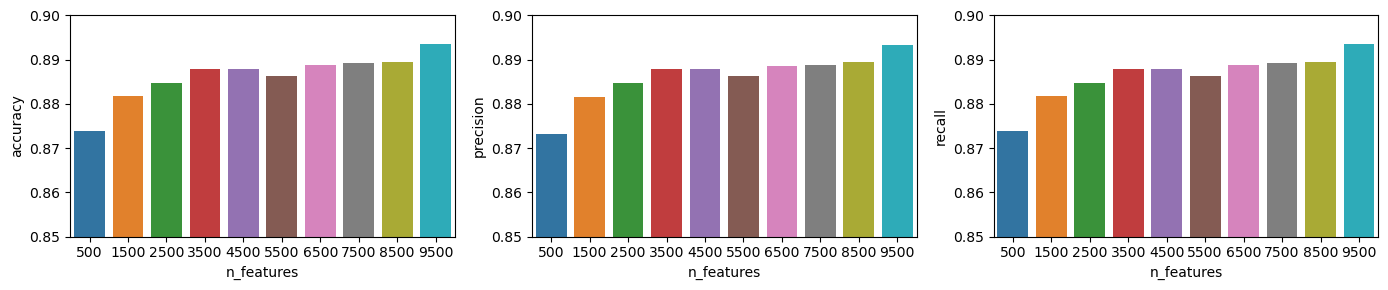

In [40]:
plot_experiment_results(nfeatures_experiment_df, col="n_features", figsize=(14, 3))

### Выводы

Да качество конечно увеличивается, чем более сложной становится наша модель и количество признаков растет. Однако можно сказать, что эти улучшения порядка одной сотой и незначительны - выходят на плато.

Важно ли, какую модель обучать — логистическую регрессию или SVM?

### Выводы

Кажется, что SVM идеально подходит, так как мы специально переформулировали задачу так, чтобы можно было сделать ядровой переход. Если мы можем свести задачу к появлению матрицы Грама от объектов выборки, то можно использовать этот метод. Однако, как было показано выше, метрики не сильно отличались. (по-хорошему надо было grid search по гиперпараметрам делать для чистоты эксперимента, но в целом одинаково).

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [41]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
class ORFPipeline(RFFPipeline):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        ORF approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        super().__init__(n_features, new_dim, use_PCA, classifier)

    def _sample_W(self, var, d):
        G = np.random.normal(loc=0, scale=1, size=(d, d)) # components are from standard normal distribution
        Q, R = np.linalg.qr(G)
        S = np.sqrt(np.random.chisquare(d, size=d))
        return (Q @ np.diag(S)) / np.sqrt(var)
    
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, ORF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        self.scaler = Normalizer().fit(X)
        X = self.scaler.transform(X)
        
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim).fit(X)
            X = self.pca.transform(X)
        
        # If D > d, it makes no sense to stack dxd features whilst D is not divisible by d
        assert self.n_features <= X.shape[1] or self.n_features % X.shape[1] == 0
        
        var = self._estimate_variance(X)
        
        if self.n_features < X.shape[1]:
            self.W = self._sample_W(var, X.shape[1])[:, :self.n_features]
        else:
            Ws = []
            for i in range(self.n_features // X.shape[1]):
                W = self._sample_W(var, X.shape[1])
                Ws.append(W)
            self.W = np.hstack(Ws)
        
        self.B = self._sample_uniform(size=self.n_features)
        new_features = self._calculate_features(X)
        
        if self.classifier == "svm":
            self.model = SVC(kernel="linear").fit(new_features, y)
        elif self.classifier == "logreg":
            self.model = LogisticRegression(max_iter=1000).fit(new_features, y)
        else:
            raise ValueError(f"Unknown classifier {self.classifier}")
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X = self.scaler.transform(X)
            
        if self.use_PCA:
            X = self.pca.transform(X)
        X = self._calculate_features(X)
        return self.model.predict_proba(X)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X = self.scaler.transform(X)
        
        if self.use_PCA:
            X = self.pca.transform(X) 
        X = self._calculate_features(X)
        return self.model.predict(X)

In [42]:
orf_pipeline = ORFPipeline(classifier="logreg").fit(x_train, y_train)

In [43]:
orf_results = statistics(orf_pipeline, x_test, y_test)

orf_results

{'accuracy': 0.8817,
 'precision': 0.881296661027957,
 'recall': 0.8816999999999998}

In [44]:
orf_pipeline2 = ORFPipeline(classifier="svm").fit(x_train, y_train)

In [45]:
orf_results2 = statistics(orf_pipeline2, x_test, y_test)

orf_results2

{'accuracy': 0.8805, 'precision': 0.8799825789690964, 'recall': 0.8805}

In [46]:
def create_dict_n_features(n_features, stats):
    stats["n_features"] = n_features
    return stats

def run_nfeatures_experiment_2():
    n_features_range = range(500, 10000, 1000)
    results = []
    
    for nf in tqdm(n_features_range, desc='Iterating over n_features'):
        orf = ORFPipeline(n_features=nf, classifier="logreg").fit(x_train[indices], y_train[indices])
        orf_results = statistics(orf, x_test, y_test)
        results.append(create_dict_n_features(nf, orf_results))
    
    return pd.DataFrame(results)

In [47]:
nfeatures_orf_experiment_df = run_nfeatures_experiment_2()

Iterating over n_features:   0%|          | 0/10 [00:00<?, ?it/s]

In [49]:
nfeatures_orf_experiment_df

,accuracy,precision,recall,n_features
0,0.8701,0.869827,0.8701,500
1,0.8859,0.885608,0.8859,1500
2,0.8867,0.886642,0.8867,2500
3,0.8840,0.883778,0.8840,3500
4,0.8878,0.887365,0.8878,4500
5,0.8861,0.885924,0.8861,5500
6,0.8882,0.888043,0.8882,6500
7,0.8894,0.889072,0.8894,7500
8,0.8880,0.887927,0.8880,8500
9,0.8897,0.889389,0.8897,9500


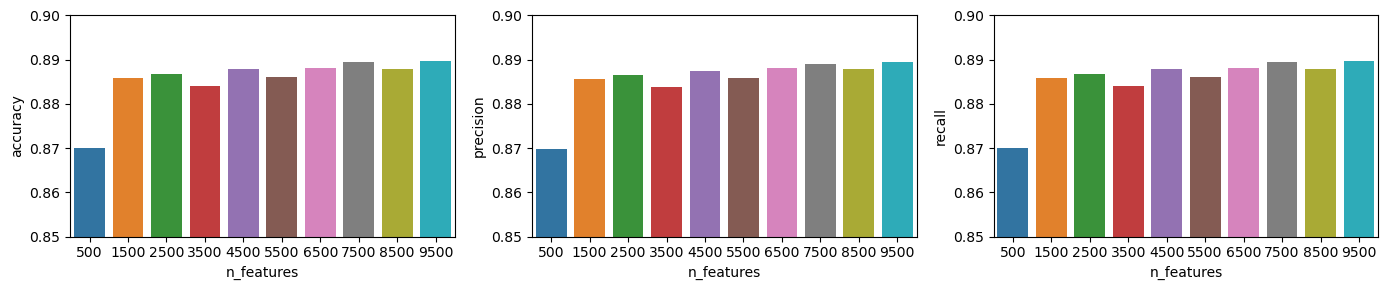

In [48]:
plot_experiment_results(nfeatures_orf_experiment_df, col="n_features", figsize=(14, 3))

### Выводы

Качество получилось таким же при обычном запуске. Эксперименты с изменением n_features тоже показали примерно такие же результаты.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪